In [1]:
import csv, cv2, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Preprocess data
Merge images from three angles, left, center and right.

In [2]:
data = pd.read_csv('./data/data/driving_log.csv',skipinitialspace=True)

In [3]:
# Using three images with offset steering
offset_angle = 0.25
# Extract center image path and steering
df_center = data[['center','steering']]
# Extract left image path and steering
df_left = data[['left','steering']]
df_left.steering += offset_angle
# Extract right image path and steering
df_right = data[['right','steering']]
df_right.steering -= offset_angle

D:\Program Files\Anaconda3\envs\RoboND\lib\site-packages\pandas\core\generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [4]:
# unify columns to concat
df_center.columns = ['path', 'steering']
df_right.columns = ['path', 'steering']
df_left.columns = ['path', 'steering']
# concat these three dataframes into one
data0 = pd.concat([df_center, df_left,df_right],ignore_index =True)

In [5]:
# Correct the file path
data0['path'] = 'data/' + data0['path']

### Extra data

In [6]:
def data_import(path):
    # The collected csv files don't have header, add them
    data = pd.read_csv(path + '/driving_log.csv', names = ['center','left','right','steering','throttle','brake','speed'])
    # Using three images with offset steering
    offset_angle = 0.25
    # Extract center image path and steering
    df_center = data[['center','steering']]
    # Extract left image path and steering
    df_left = data[['left','steering']]
    df_left.steering += offset_angle
    # Extract right image path and steering
    df_right = data[['right','steering']]
    df_right.steering -= offset_angle
    # unify columns to concat
    df_center.columns = ['path', 'steering']
    df_right.columns = ['path', 'steering']
    df_left.columns = ['path', 'steering']
    # concat these three dataframes into one
    df_result = pd.concat([df_center, df_left,df_right],ignore_index =True)
    return df_result

In [7]:
data1 = data_import('./data/run1')
data2 = data_import('./data/run2')
data3 = data_import('./data/run3')

D:\Program Files\Anaconda3\envs\RoboND\lib\site-packages\pandas\core\generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [8]:
data_all = pd.concat([data0, data1, data2, data3],ignore_index =True)

### Data visulization

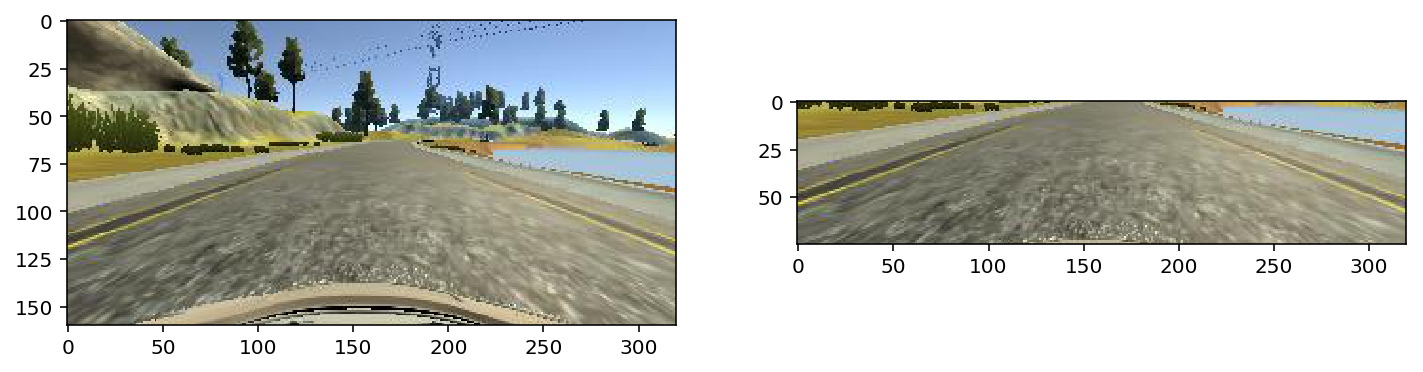

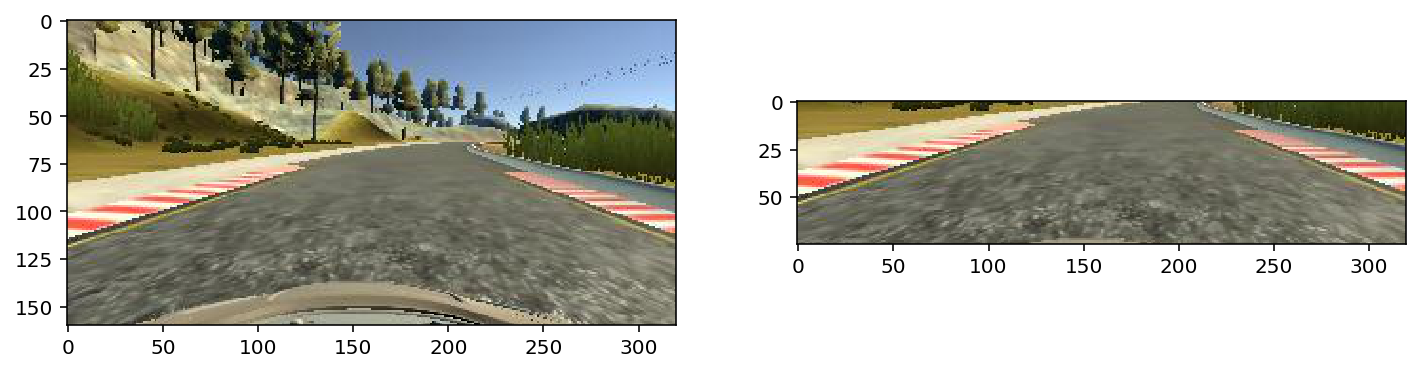

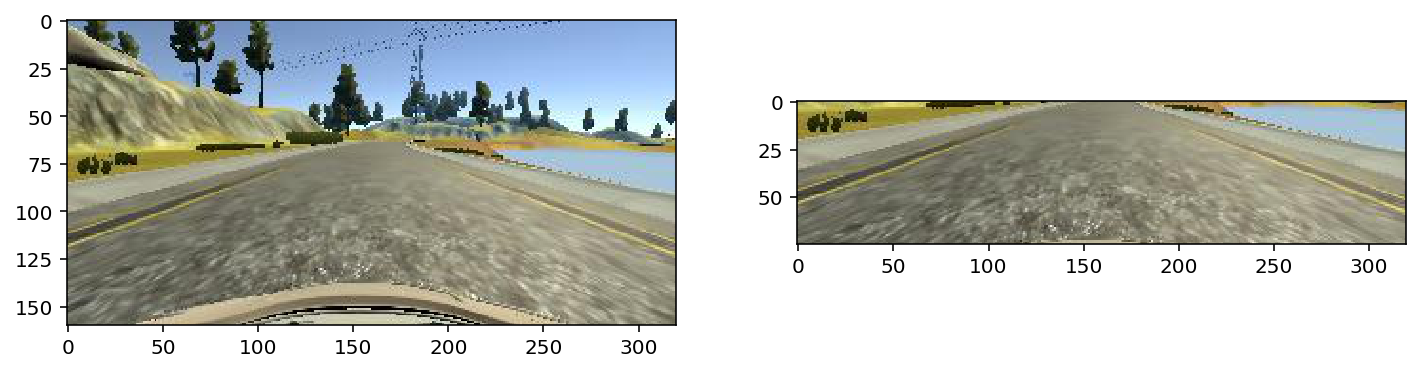

In [9]:
import random
for i in range(0,3):
    index = random.randint(0, 2000)
    path_list = data0['path'][index].split('/')
    img_path = './data/' + path_list[-3] + '/' + path_list[-2] + '/' + path_list[-1]
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(12,7))
    plt.subplot(1,2,1)
    plt.imshow(image) 
    crop_img = image[65:140, :,:]
    plt.subplot(1,2,2)
    plt.imshow(crop_img) 

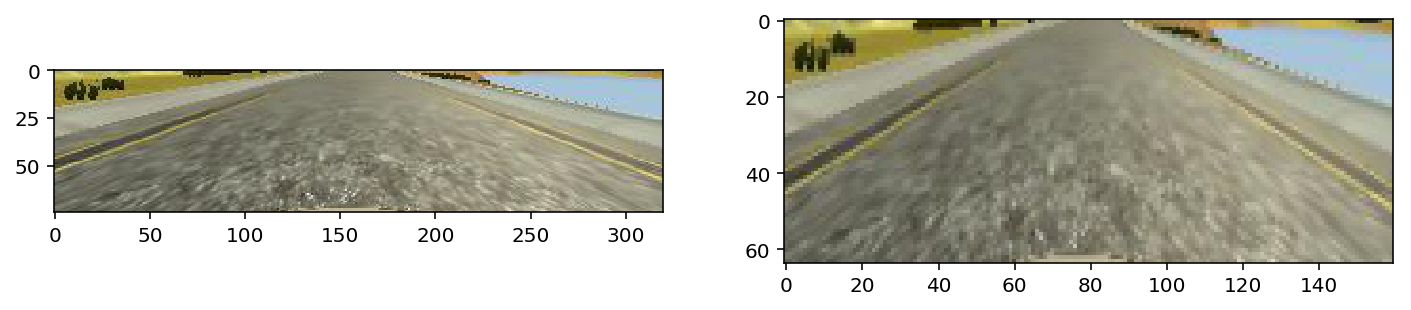

In [10]:
resize_img = cv2.resize(crop_img,(160,64))
plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
plt.imshow(crop_img) 
plt.subplot(1,2,2)
plt.imshow(resize_img) 

In [11]:
from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(data_all, test_size=0.1)

In [12]:
epochs = 40
batch_size = 128
learning_rate = 0.001
train_steps = len(train_samples)//batch_size
validation_steps = len(validation_samples)//batch_size

In [13]:
from random import getrandbits

def generator(samples, batch_size=32):
    '''data generator'''
    num_samples = len(samples)
    while 1:  # Loop forever so the generator never terminates
        for offset in range(0, num_samples):
            batch_samples = samples[offset:offset+batch_size]
            
            images = []
            angles = []
            for index in range(0, batch_size):
                # replace \\ to / for the collected data path
                img_name = batch_samples.iloc[index]['path'].replace('\\','/')
                path_dic = img_name.split('/')
                file_path = './data/' +  path_dic[-3] + '/' +  path_dic[-2] + '/' +  path_dic[-1]
               
                image = cv2.imread(file_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
                angle = float(batch_samples.iloc[index]['steering'])
                # generate true or false randomly
                if bool(getrandbits(1)):
                    image = np.fliplr(image)
                    angle = - angle       
                images.append(image)
                angles.append(angle)
            
            X_train = np.array(images)
            y_train = np.array(angles)
            yield X_train, y_train

### Model

In [14]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Dropout
from keras.layers import Conv2D, Cropping2D, SeparableConv2D
from keras.optimizers import Adam

Using TensorFlow backend.


In [15]:
from keras.backend import tf as ktf
def resize_img(input):
    from keras.backend import tf as ktf
    return ktf.image.resize_images(input, (64, 160))

In [16]:
model = Sequential()
model.add(Cropping2D(cropping=((65,20),(0,0)), input_shape=(160,320,3)))
model.add(Lambda(resize_img))
model.add(Lambda(lambda x: x/255.0 - 0.5))
model.add(Conv2D(16, kernel_size=(5, 5), strides=(1,1), 
                 padding='same', activation='relu'))

model.add(Conv2D(32, kernel_size=(3, 3), strides=(2,2), 
                 padding='same', activation='relu'))

model.add(Conv2D(32, kernel_size=(3, 3), strides=(2,2), 
                padding='same', activation='relu'))

model.add(Conv2D(64, kernel_size=(3, 3), strides=(2,2), 
                 padding='same', activation='relu'))

model.add(Conv2D(64, kernel_size=(3, 3), strides=(2,2), 
                 padding='same', activation='relu'))

model.add(Conv2D(128, kernel_size=(3, 3), strides=(2,2), 
                 padding='same', activation='relu'))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1))

optimizer = Adam(lr=learning_rate)
model.compile(loss='mse', optimizer=optimizer)

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_1 (Cropping2D)    (None, 75, 320, 3)        0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 64, 160, 3)        0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 64, 160, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 160, 16)       1216      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 80, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 40, 32)        9248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 20, 64)         18496     
__________

### Model training on Track1

In [18]:
from keras.models import load_model

# If the model exists, load model from h5:
read_model = True
if read_model:
    if os.path.isfile("model.h5"):
        model = load_model("model.h5")

In [220]:
train_generator = generator(train_samples, batch_size=batch_size)
validation_generator = generator(validation_samples, batch_size=batch_size)

In [221]:
loss_value = []
val_loss_value = []
final_loss_value = []
final_val_loss_value = []
total_epochs = 0

In [222]:
from keras.callbacks import ModelCheckpoint
filepath="weights.h5"
model_cb = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, mode='auto', period=1)
callbacks = [model_cb]

In [224]:
history = model.fit_generator(train_generator, 
                              validation_data=validation_generator,
                              steps_per_epoch=train_steps,
                              validation_steps=validation_steps, 
                              epochs=epochs,callbacks=callbacks)

Epoch 1/40
240/240 [==============================] - 84s 349ms/step - loss: 0.0374 - val_loss: 0.0303
Epoch 2/40
240/240 [==============================] - 79s 329ms/step - loss: 0.0216 - val_loss: 0.0295
Epoch 3/40
240/240 [==============================] - 80s 331ms/step - loss: 0.0183 - val_loss: 0.0276
Epoch 4/40
240/240 [==============================] - 79s 329ms/step - loss: 0.0172 - val_loss: 0.0338
Epoch 5/40
240/240 [==============================] - 79s 329ms/step - loss: 0.0162 - val_loss: 0.0296
Epoch 6/40
240/240 [==============================] - 79s 330ms/step - loss: 0.0174 - val_loss: 0.0325
Epoch 7/40
240/240 [==============================] - 79s 329ms/step - loss: 0.0164 - val_loss: 0.0237
Epoch 8/40
240/240 [==============================] - 79s 329ms/step - loss: 0.0189 - val_loss: 0.0261
Epoch 9/40
240/240 [==============================] - 80s 331ms/step - loss: 0.0152 - val_loss: 0.0274
Epoch 10/40
240/240 [==============================] - 79s 331ms/step - l

In [225]:
# merge loss values of all epoches
loss_value = history.history['loss']
val_loss_value = history.history['val_loss']
final_loss_value += loss_value
final_val_loss_value += val_loss_value
# update epoches num
total_epochs += epochs

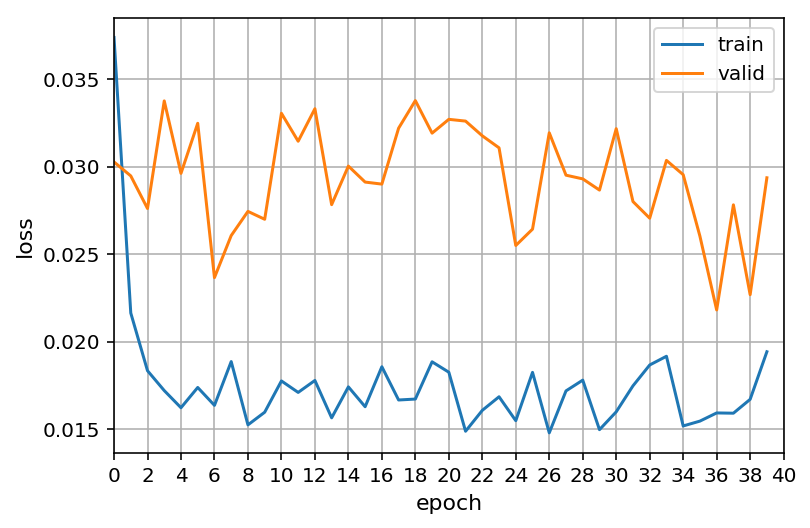

In [226]:
# summarize history for loss
plt.plot(final_loss_value)
plt.plot(final_val_loss_value)

# plt.title('model loss')
plt.ylabel('loss', fontsize=11)
plt.xlabel('epoch', fontsize=11)
plt.legend(['train', 'valid'], loc='best')
plt.xlim((0,total_epochs))
plt.xticks(np.arange(0, total_epochs+1, 2))
plt.grid()
# plt.savefig("/loss.png", dpi=300)
plt.show()

In [227]:
# save model
model.save('model.h5')

## Model training on Track2

In [186]:
def data_import_t2(path, multiple_cameras=True):
    # The collected csv files don't have header, add them
    data = pd.read_csv(path + '/driving_log.csv', names = ['center','left','right','steering','throttle','brake','speed'])
    # Using three images with offset steering
    offset_angle = 0.25
    # Extract center image path and steering
    df_center = data[['center','steering']]
    # Extract left image path and steering
    df_left = data[['left','steering']]
    df_left.steering += offset_angle
    # Extract right image path and steering
    df_right = data[['right','steering']]
    df_right.steering -= offset_angle
    # unify columns to concat
    df_center.columns = ['path', 'steering']
    df_right.columns = ['path', 'steering']
    df_left.columns = ['path', 'steering']
    # concat these three dataframes into one
    if multiple_cameras:
        df_result = pd.concat([df_center, df_left,df_right],ignore_index =True)
    else:
        df_result = df_center
    return df_result

In [279]:
multiple_cameras = True
# t2_data1 = data_import('./data/t2run1')
# t2_data2 = data_import('./data/t2run2')
# t2_data3 = data_import('./data/t2run3')
# t2_data4 = data_import('./data/t2run4')
# t2_data5 = data_import_t2('./data/t2run5')
# t2_data6 = data_import_t2('./data/t2run6')
t2_data7 = data_import_t2('./data/t2run7',multiple_cameras)
t2_data8 = data_import_t2('./data/t2run8',multiple_cameras)
t2_data9 = data_import_t2('./data/t2run9',multiple_cameras)
t2_data10 = data_import_t2('./data/t2run10',multiple_cameras)
t2_data11 = data_import_t2('./data/t2run11',multiple_cameras)
t2_data12 = data_import_t2('./data/t2run12',multiple_cameras)
t2_data13 = data_import_t2('./data/t2run13',multiple_cameras)
t2_data_all = pd.concat([t2_data7, t2_data8[:-100] ,t2_data9[:-100], t2_data10[:-100], 
                         t2_data11[:-100], t2_data12[:-100], t2_data13],ignore_index =True)

/usr/lib64/python3.4/dist-packages/pandas/core/generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [285]:
t2_data_all = t2_data13

In [255]:
img_name = t2_data7.iloc[80]['path'].replace('\\','/')
path_dic = img_name.split('/')
file_path = './data/' +  path_dic[-3] + '/' +  path_dic[-2] + '/' +  path_dic[-1]

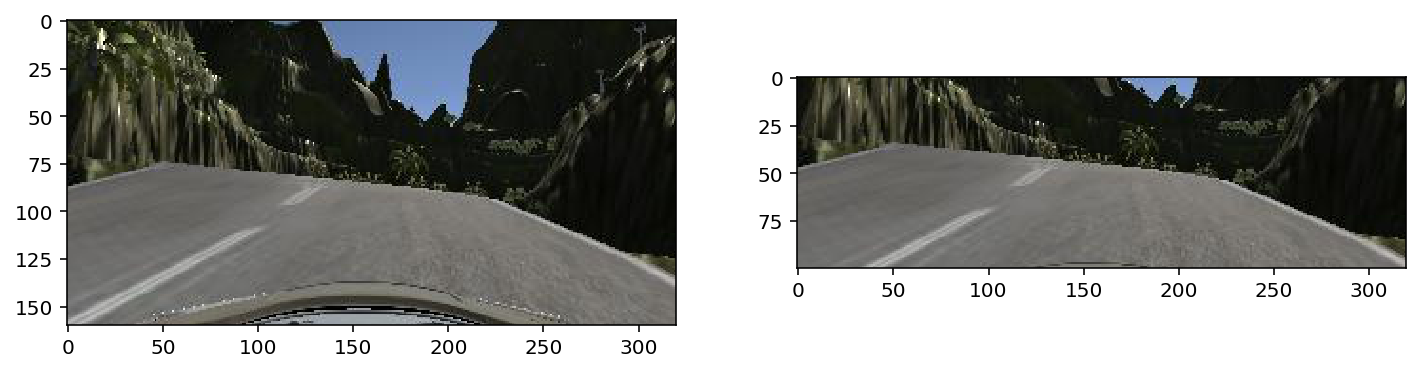

In [256]:
image = cv2.imread(file_path)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12,7))
plt.subplot(1,2,1)
plt.imshow(image) 
crop_img = image[40:140, :,:]
plt.subplot(1,2,2)
plt.imshow(crop_img) 

In [257]:
from random import getrandbits

def generator_t2(samples, batch_size=32):
    '''data generator'''
    num_samples = len(samples)
    while 1:  # Loop forever so the generator never terminates
        for offset in range(0, num_samples):
            batch_samples = samples[offset:offset+batch_size]
            
            images = []
            angles = []
            for index in range(0, batch_size):
                # replace \\ to / for the collected data path
                img_name = batch_samples.iloc[index]['path'].replace('\\','/')
                path_dic = img_name.split('/')
                file_path = './data/' +  path_dic[-3] + '/' +  path_dic[-2] + '/' +  path_dic[-1]
                
                image = cv2.imread(file_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
                angle = float(batch_samples.iloc[index]['steering'])
                # generate true or false randomly
#                 if bool(getrandbits(1)):
#                     image = np.fliplr(image)
#                     angle = - angle       
                images.append(image)
                angles.append(angle)
            
            X_train = np.array(images)
            y_train = np.array(angles)
            yield X_train, y_train

In [286]:
train_samples_t2, validation_samples_t2 = train_test_split(t2_data_all, test_size=0.1, random_state=42)

In [287]:
epochs = 5
batch_size = 128
learning_rate = 0.001
train_steps = len(train_samples_t2)//batch_size
validation_steps = len(validation_samples_t2)//batch_size

In [288]:
train_generator_t2 = generator_t2(train_samples_t2, batch_size=batch_size)
validation_generator_t2 = generator_t2(validation_samples_t2, batch_size=batch_size)

In [273]:
from keras.backend import tf as ktf
def resize_img(input):
    from keras.backend import tf as ktf
    return ktf.image.resize_images(input, (66, 200))

In [274]:
model2 = Sequential()
model2.add(Cropping2D(cropping=((40,20),(0,0)), input_shape=(160,320,3)))
model2.add(Lambda(resize_img))
model2.add(Lambda(lambda x: x/255.0 - 0.5))
model2.add(Conv2D(24, kernel_size=(5, 5), strides=(2,2), 
                 padding='valid', activation='relu', name='Conv_1'))

model2.add(Conv2D(36, kernel_size=(5, 5), strides=(2,2), 
                 padding='valid', activation='relu', name='Conv_2'))

model2.add(Conv2D(48, kernel_size=(5, 5), strides=(2,2), 
                 padding='valid', activation='relu', name='Conv_3'))

model2.add(Conv2D(64, kernel_size=(3, 3), strides=(1,1), 
                 padding='valid', activation='relu', name='Conv_4'))

model2.add(Conv2D(64, kernel_size=(3, 3), strides=(1,1), 
                 padding='valid', activation='relu', name='Conv2D_5'))

model2.add(Flatten(name='flatten_1'))
model2.add(Dense(100, activation='relu', name='dense_1'))
model2.add(Dropout(0.5))
model2.add(Dense(50, activation='relu', name='dense_2'))
model2.add(Dropout(0.5))
model2.add(Dense(10, activation='relu', name='dense_3'))
model2.add(Dropout(0.5))
model2.add(Dense(1))

optimizer = Adam(lr=learning_rate)
model2.compile(loss='mse', optimizer=optimizer)

In [263]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_33 (Cropping2D)   (None, 100, 320, 3)       0         
_________________________________________________________________
lambda_65 (Lambda)           (None, 66, 200, 3)        0         
_________________________________________________________________
lambda_66 (Lambda)           (None, 66, 200, 3)        0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 31, 98, 24)        1824      
_________________________________________________________________
Conv_2 (Conv2D)              (None, 14, 47, 36)        21636     
_________________________________________________________________
Conv_3 (Conv2D)              (None, 5, 22, 48)         43248     
_________________________________________________________________
Conv_4 (Conv2D)              (None, 3, 20, 64)         27712     
__________

In [264]:
loss_value2 = []
val_loss_value2 = []
final_loss_value2 = []
final_val_loss_value2 = []
total_epochs2 = 0

In [276]:
model2 = load_model("t2_model_v1.h5")

In [265]:
from keras.models import load_model

# If the model exists, load model from h5:
read_model = True
if read_model:
    if os.path.isfile("t2_model.h5"):
        model2 = load_model("t2_model.h5")

In [266]:
from keras.callbacks import ModelCheckpoint
filepath="t2_weights.h5"
model_cb = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, mode='auto', period=1)
callbacks = [model_cb]

In [289]:
t2_history = model2.fit_generator(train_generator_t2, 
                              validation_data=validation_generator_t2,
                              steps_per_epoch=train_steps,
                              validation_steps=validation_steps, 
                              epochs=2,callbacks=callbacks)

Epoch 1/2
9/9 [==============================] - 3s 363ms/step - loss: 0.0852 - val_loss: 0.0733
Epoch 2/2
9/9 [==============================] - 3s 289ms/step - loss: 0.0784 - val_loss: 0.0755


In [290]:
# save model
model2.save('t2_model.h5')

In [199]:
# merge loss values of all epoches
loss_value2 = t2_history.history['loss']
val_loss_value2 = t2_history.history['val_loss']
final_loss_value2 += loss_value2
final_val_loss_value2 += val_loss_value2
# update epoches num
total_epochs2 += epochs

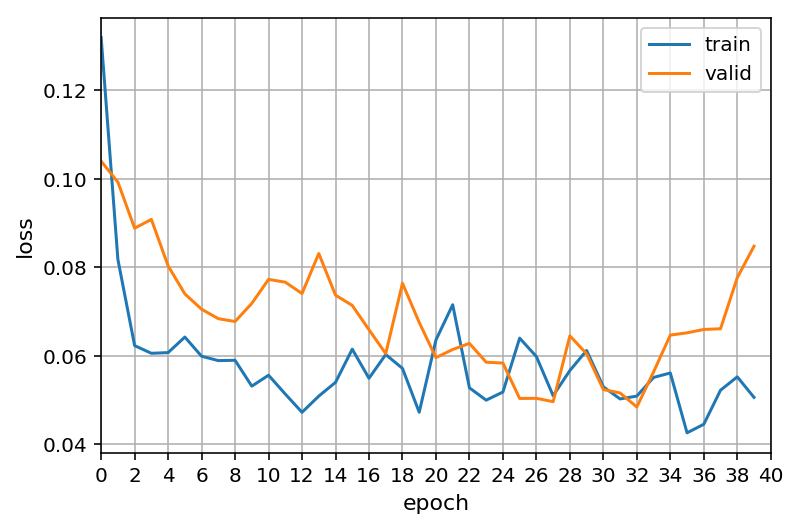

In [200]:
# summarize history for loss
plt.plot(final_loss_value2)
plt.plot(final_val_loss_value2)

# plt.title('model loss')
plt.ylabel('loss', fontsize=11)
plt.xlabel('epoch', fontsize=11)
plt.legend(['train', 'valid'], loc='best')
plt.xlim((0,total_epochs2))
plt.xticks(np.arange(0, total_epochs2+1, 2))
plt.grid()
# plt.savefig("/loss.png", dpi=300)
plt.show()